# 401 CNN

View more, visit my tutorial page: https://morvanzhou.github.io/tutorials/
My Youtube Channel: https://www.youtube.com/user/MorvanZhou

Dependencies:
* torch: 0.1.11
* torchvision
* matplotlib

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
torch.manual_seed(1)    # reproducible

In [3]:
# Hyper Parameters
EPOCH = 1               # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 50
LR = 0.001              # learning rate
DOWNLOAD_MNIST = True   # set to False if you have downloaded

In [4]:
# Mnist digits dataset
train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,                                     # this is training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,                        # download it if you don't have it
)

torch.Size([60000, 28, 28])
torch.Size([60000])
ToTensor()
./mnist/
raw
processed
training.pt
test.pt
['http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', 'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', 'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', 'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz']


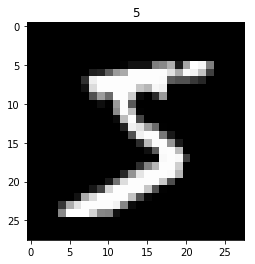

In [5]:
# plot one example
print(train_data.train_data.size())                 # (60000, 28, 28)
print(train_data.train_labels.size())               # (60000)
print(train_data.transform)                         # ToTensor()
print(train_data.root)                              # './mnist/'
print(train_data.raw_folder)                        # 'raw'
print(train_data.processed_folder)                  # 'processed'
print(train_data.training_file)                     # 'training.pt'
print(train_data.test_file)                         # 'test.pt'
print(train_data.urls)                              
"""
['http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
 'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
 'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
 'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz']
"""
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[0])
plt.show()

In [6]:
# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

In [7]:
print(train_loader.dataset)
"""
Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./mnist/
    Transforms (if any): ToTensor()
    Target Transforms (if any): Nonev
"""
print(train_loader.batch_size)

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./mnist/
    Transforms (if any): ToTensor()
    Target Transforms (if any): None
50


In [8]:
# convert test data into Variable, pick 2000 samples to speed up testing
test_data = torchvision.datasets.MNIST(root='./mnist/', train=False)
# torch.max(test_data.test_data): tensor(255, dtype=torch.uint8)
# torch.min(test_data.test_data): tensor(0, dtype=torch.uint8)
test_x = Variable(torch.unsqueeze(test_data.test_data, dim=1)).type(torch.FloatTensor)[:2000]/255.   # shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)
test_y = test_data.test_labels[:2000] # test_y.type(): 'torch.LongTensor'

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after conv2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (1, 28, 28)
            #nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)
            nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x    # return x for visualization

In [10]:
cnn = CNN()
print(cnn)  # net architecture

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [11]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

Epoch:  0 | train loss: 2.3105 | test accuracy: 0.06


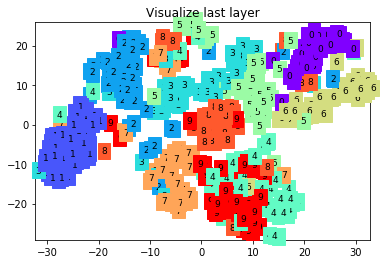

Epoch:  0 | train loss: 0.1274 | test accuracy: 0.87


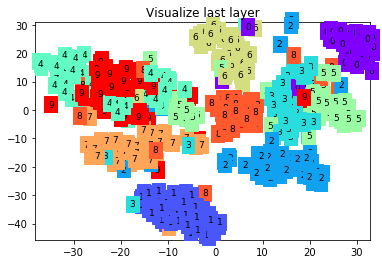

Epoch:  0 | train loss: 0.4059 | test accuracy: 0.93


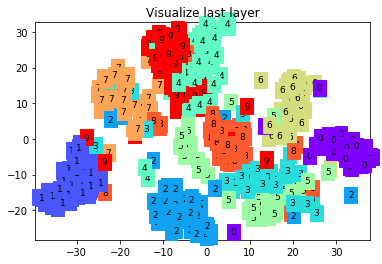

Epoch:  0 | train loss: 0.1955 | test accuracy: 0.94


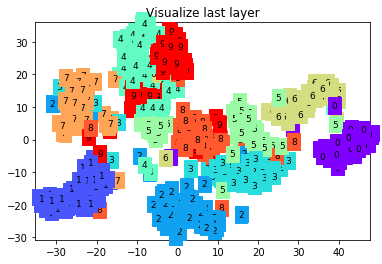

Epoch:  0 | train loss: 0.1230 | test accuracy: 0.96


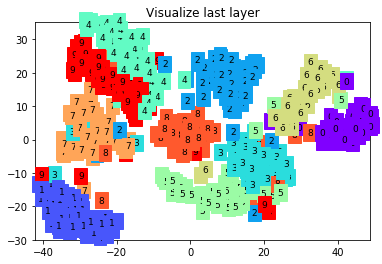

Epoch:  0 | train loss: 0.2223 | test accuracy: 0.96


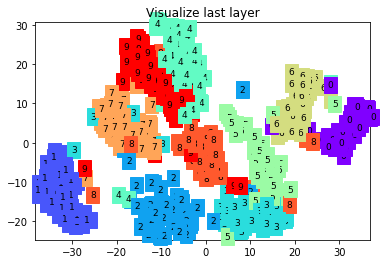

Epoch:  0 | train loss: 0.0241 | test accuracy: 0.97


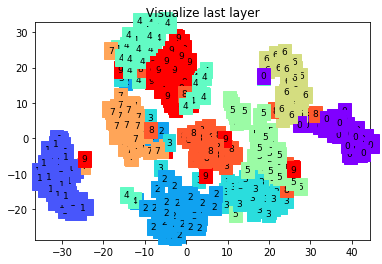

Epoch:  0 | train loss: 0.2170 | test accuracy: 0.97


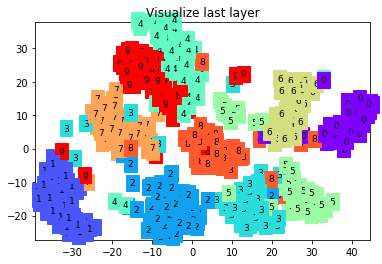

Epoch:  0 | train loss: 0.0423 | test accuracy: 0.97


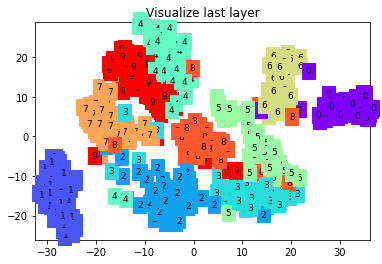

Epoch:  0 | train loss: 0.0572 | test accuracy: 0.98


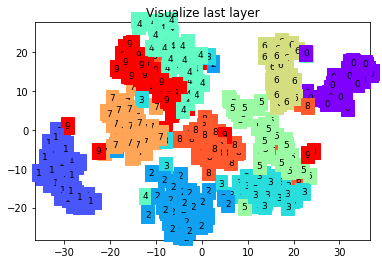

Epoch:  0 | train loss: 0.0323 | test accuracy: 0.98


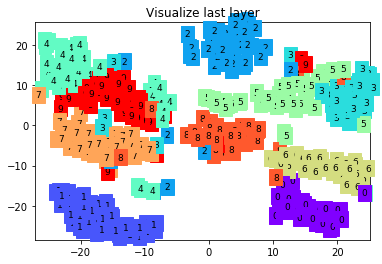

Epoch:  0 | train loss: 0.0256 | test accuracy: 0.98


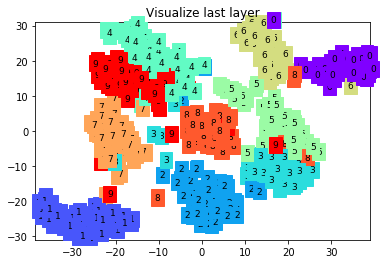

In [12]:
# following function (plot_with_labels) is for visualization, can be ignored if not interested
from matplotlib import cm
try: from sklearn.manifold import TSNE; HAS_SK = True
except: HAS_SK = False; print('Please install sklearn for layer visualization')
def plot_with_labels(lowDWeights, labels):
    plt.cla()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)

plt.ion()
# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
        b_x = Variable(x)   # batch x
        b_y = Variable(y)   # batch y

        # cnn() return (last layer's output, 2nd last layer's output)
        output = cnn(b_x)[0]               # cnn output
        """
         `input` has to be a Tensor of size either :math:`(minibatch, C)` or
         |  :math:`(minibatch, C, d_1, d_2, ..., d_K)`
         |  with :math:`K \geq 2` for the `K`-dimensional case (described later).
         |  
         |  This criterion expects a class index (0 to `C-1`) as the
         |  `target` for each value of a 1D tensor of size `minibatch`
        """
        # output.shape: torch.Size([50, 10], b_y.shape: torch.Size([50])
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        if step % 100 == 0:
            test_output, last_layer = cnn(test_x)
            # torch.max() returns (max_value, max_index)
            # to fix /opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
            pred_y = torch.max(test_output, 1)[1].data #.squeeze()
            accuracy = (pred_y == test_y).sum().item() / float(test_y.size(0))
            # /opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
            #print('Epoch: ', epoch, '| train loss: %.4f' % loss.data[0], '| test accuracy: %.2f' % accuracy)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.item(), '| test accuracy: %.2f' % accuracy)
            if HAS_SK:
                # Visualization of trained flatten layer (T-SNE)
                tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
                plot_only = 500
                low_dim_embs = tsne.fit_transform(last_layer.data.numpy()[:plot_only, :])
                labels = test_y.numpy()[:plot_only]
                plot_with_labels(low_dim_embs, labels)
plt.ioff()

In [13]:
# print 10 predictions from test data
test_output, _ = cnn(test_x[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy() #.squeeze()
print(pred_y, 'prediction number')
print(test_y[:10].numpy(), 'real number')

[7 2 1 0 4 1 4 9 5 9] prediction number
[7 2 1 0 4 1 4 9 5 9] real number
